In [1]:
# import some common libraries
import numpy as np
import cv2
import torch
import os
import io
import argparse
import pickle
import json
import tqdm

# import detectron2
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2_diff.utils.visualizer import Visualizer
# from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2_diff.config.defaults import add_detectron2_diff_config, add_detectron2_diff_config_att

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, \
    fast_rcnn_inference_single_image

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())


vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())
        
MetadataCatalog.get("vg").attr_classes = vg_attrs
MetadataCatalog.get("vg").thing_classes = vg_classes

In [3]:
cfg = get_cfg()
add_detectron2_diff_config_att(cfg)
cfg.merge_from_file("./configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.WEIGHTS = "./model/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



/media/abiten/SSD-DATA/dom_adapt/miniconda/envs/detectron2/lib/python3.8/site-packages/torch/cuda/__init__.py:87: UserWarning: 
    Found GPU1 GeForce GT 640 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [18]:
NUM_OBJECTS = 36

ims = []
for fname in os.listdir("data/images"):
    if os.path.splitext(fname)[-1] == '.jpg':
        im = cv2.imread("data/images/" + fname)
        ims.append(im)
ims = ims[:6]
    
from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image

def doit(raw_images):
    with torch.no_grad():
        # Preprocessing
        inputs = []
        for raw_image in raw_images:
            image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs.append({"image": image, "height": raw_image.shape[0], "width": raw_image.shape[1]})
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Generate proposals with RPN
        proposals, _ = predictor.model.proposal_generator(images, features, None)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [x.proposal_boxes for x in proposals]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # (sum_proposals, 2048), pooled to 1x1
        
        # Predict classes and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        rcnn_outputs = FastRCNNOutputs(
                predictor.model.roi_heads.box2box_transform,
                pred_class_logits,
                pred_proposal_deltas,
                proposals,
                predictor.model.roi_heads.smooth_l1_beta,
            )
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        # Fixed-number NMS
        instances_list, ids_list = [], []
        probs_list = rcnn_outputs.predict_probs()
        boxes_list = rcnn_outputs.predict_boxes()
        for probs, boxes, image_size in zip(probs_list, boxes_list, images.image_sizes):
            for nms_thresh in np.arange(0.5, 1.0, 0.1):
                instances, ids = fast_rcnn_inference_single_image(
                    boxes, probs, image_size, 
                    score_thresh=0.2, nms_thresh=nms_thresh, topk_per_image=NUM_OBJECTS
                )
                if len(ids) == NUM_OBJECTS:
                    break
            instances_list.append(instances)
            ids_list.append(ids)
#         instances_list, ids_list = rcnn_outputs.inference(
#             score_thresh=0.2, nms_thresh=0.6, topk_per_image=36
#         )
        max_attr_prob = max_attr_prob.split(rcnn_outputs.num_preds_per_image)
        max_attr_label = max_attr_label.split(rcnn_outputs.num_preds_per_image)
        box_features = box_features.split(rcnn_outputs.num_preds_per_image, dim=0)
        for ix, ids in enumerate(ids_list):
            # roi_features_list.append(features_list[ix][ids].detach())
            instances_list[ix].attr_scores = max_attr_prob[ix][ids].detach()
            instances_list[ix].attr_classes = max_attr_label[ix][ids].detach()
            # Pooled features
#             instances_list[ix].roi_features = box_features[ix][ids].mean(dim=[2, 3]).detach()
            # Non-pooled features: 14x14x2048
            # instances_list[ix].roi_features = box_features[ix][ids].detach()
        # Post processing for features
        features_list = feature_pooled.split(rcnn_outputs.num_preds_per_image) # (sum_proposals, 2048) --> [(p1, 2048), (p2, 2048), ..., (pn, 2048)]
        roi_features_list = []
        for ids, features in zip(ids_list, features_list):
            roi_features_list.append(features[ids].detach())
        
        # Post processing for bounding boxes (rescale to raw_image)
        raw_instances_list = []
        for instances, input_per_image, image_size in zip(instances_list, inputs, images.image_sizes):
                height = input_per_image.get("height", image_size[0])
                width = input_per_image.get("width", image_size[1])
                raw_instances = detector_postprocess(instances, height, width)
                raw_instances_list.append(raw_instances)
        return raw_instances_list, roi_features_list
    
torch.cuda.empty_cache()
instances_list, features_list = doit(ims)

print("Extracted features for %d images." % len(instances_list))


Extracted features for 6 images.


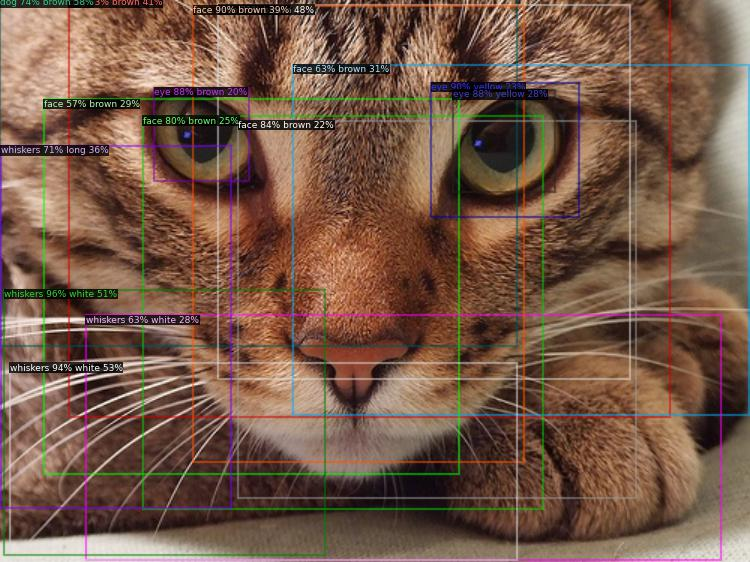

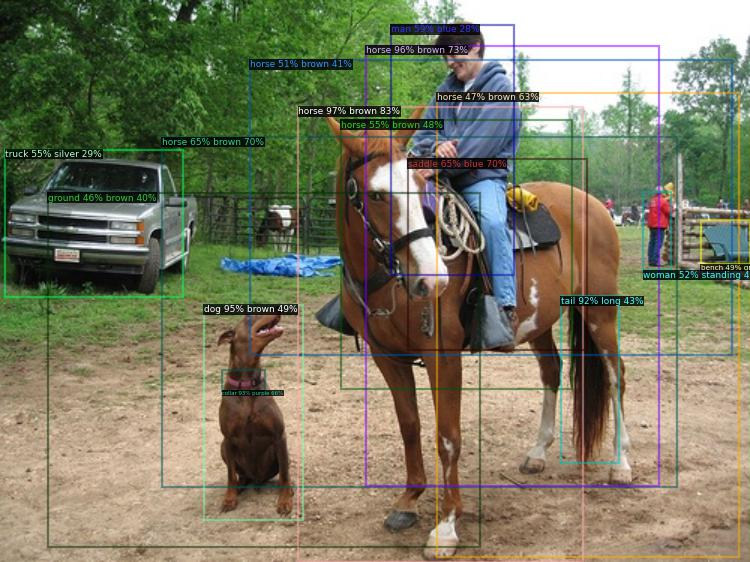

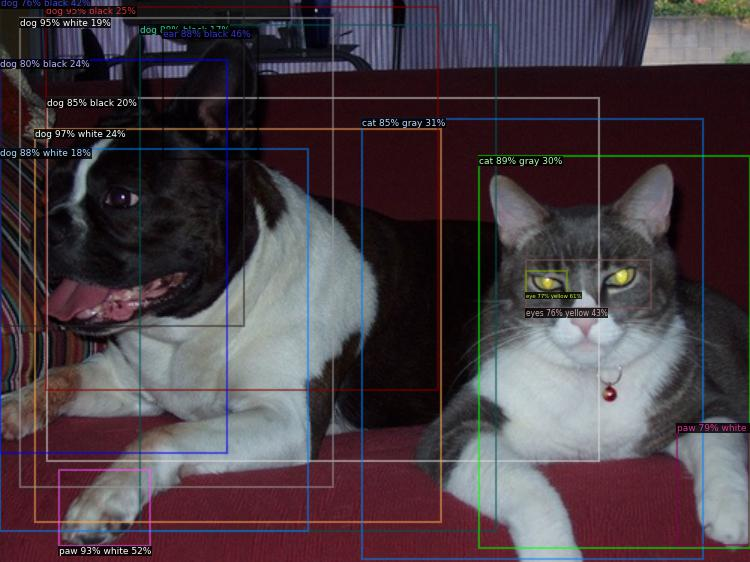

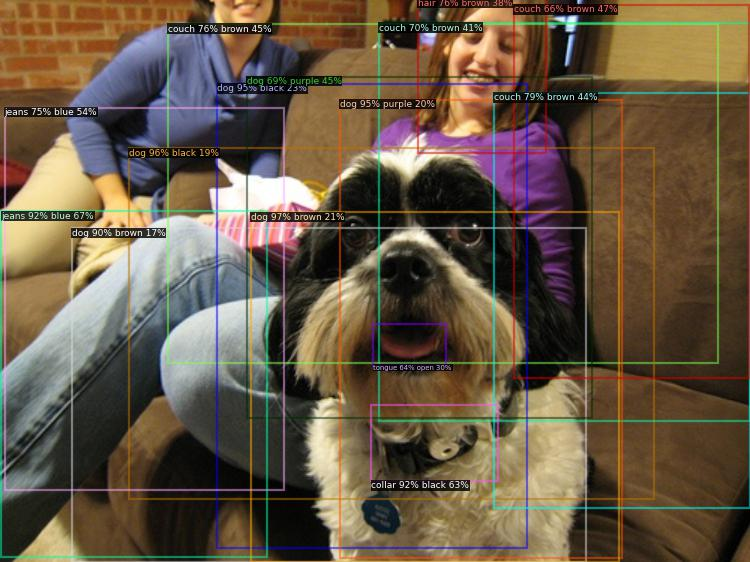

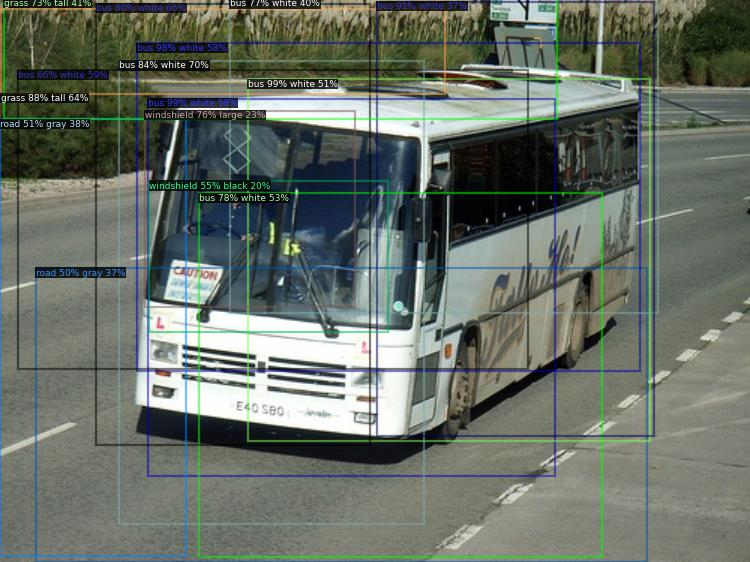

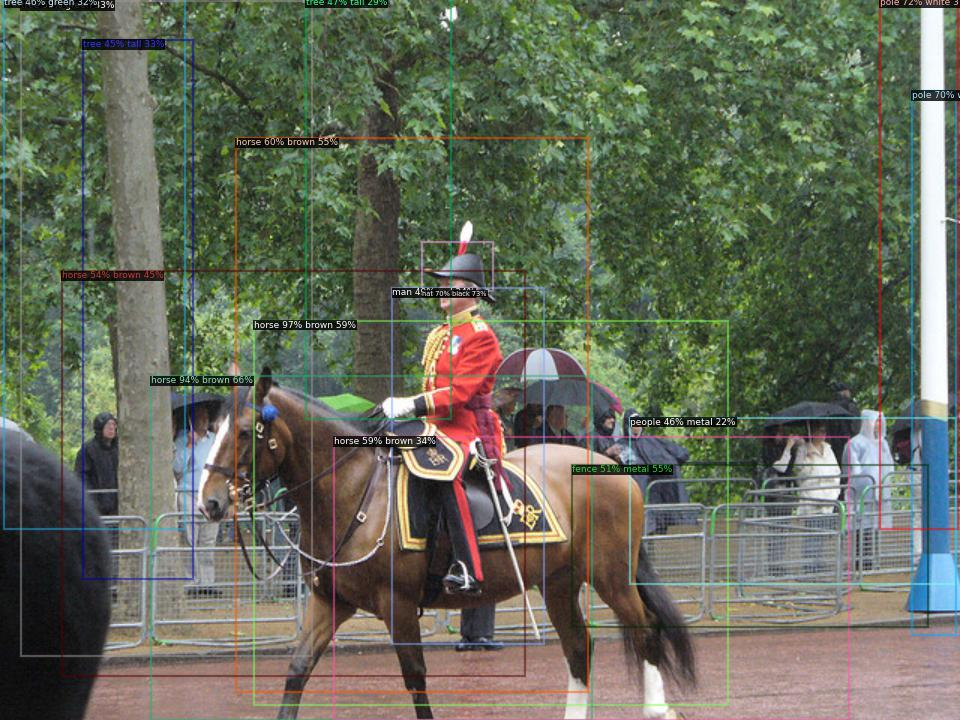

In [20]:
for instances, im in zip(instances_list, ims):
#     print(instances)
    pred = instances.to('cpu')
    v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.5)
    v = v.draw_instance_predictions(pred[:15])
    showarray(v.get_image()[:, :, ::-1])

In [12]:
for instances, features in zip(instances_list, features_list):
    pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(features)
    pred_class_probs = torch.nn.functional.softmax(pred_class_logits, -1)[:, :-1]
    max_probs, max_classes = pred_class_probs.max(-1)
    print("%d objects are different, it is because the classes-aware NMS process" % (NUM_OBJECTS - torch.eq(instances.pred_classes, max_classes).sum().item()))
    print("The total difference of score is %0.4f" % (instances.scores - max_probs).abs().sum().item())

4 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.3419
4 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.3891
0 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.0000
1 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.0721
3 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.5920
1 objects are different, it is because the classes-aware NMS process
The total difference of score is 0.0877


In [3]:
cfg = get_cfg()
add_detectron2_diff_config_att(cfg)
cfg.merge_from_file("./configs/default/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.WEIGHTS = "./model/mask_rcnn_X_101_32x8d_FPN_3x.pkl"
predictor = DefaultPredictor(cfg)

In [4]:
ims = []
for fname in os.listdir("data/images"):
    if os.path.splitext(fname)[-1] == '.jpg':
        im = cv2.imread("data/images/" + fname)
        ims.append(im)
# ims = ims[:6]

In [5]:
# inputs = []
# for raw_image in ims:
#     image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
#     image = torch.as_tensor(image.astype("float32"))
#     inputs.append({"image": image, "height": raw_image.shape[0], "width": raw_image.shape[1]})
# images = predictor.model.preprocess_image(inputs)
# im = ims[0]


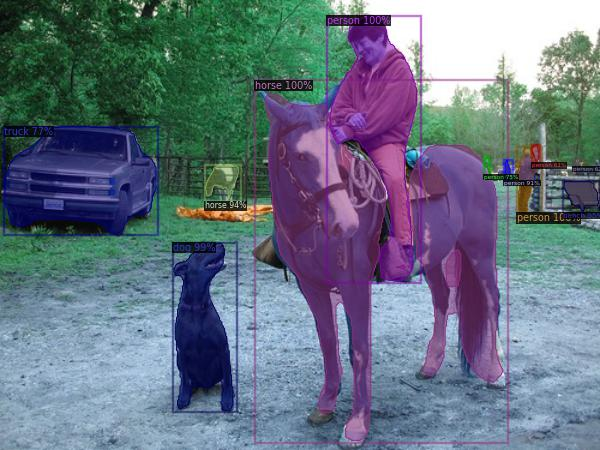

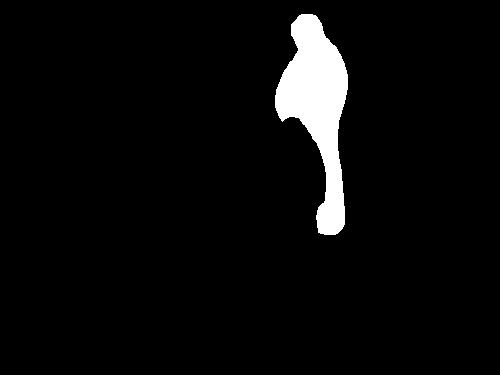

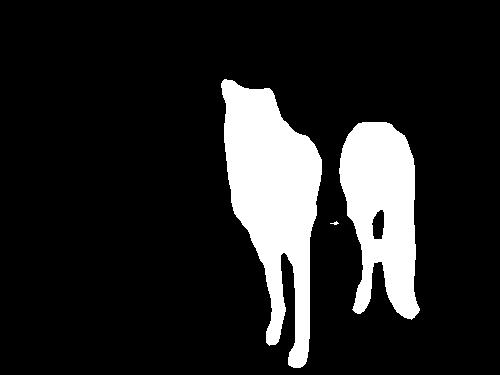

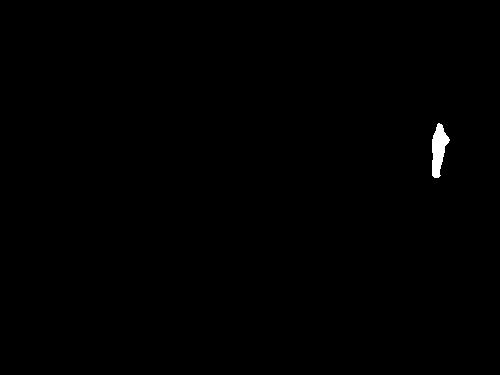

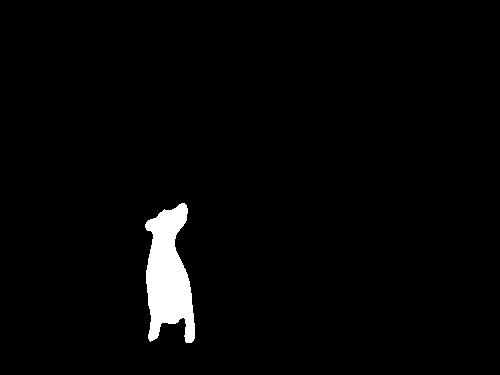

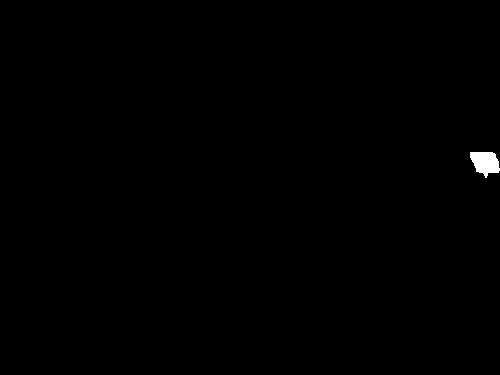

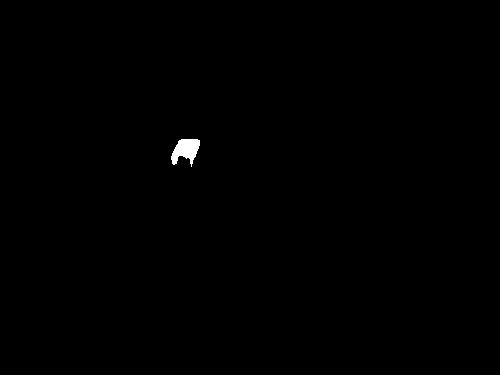

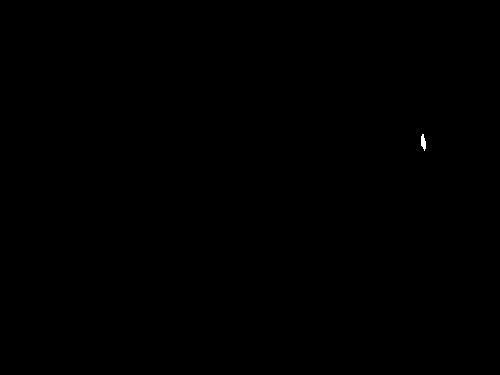

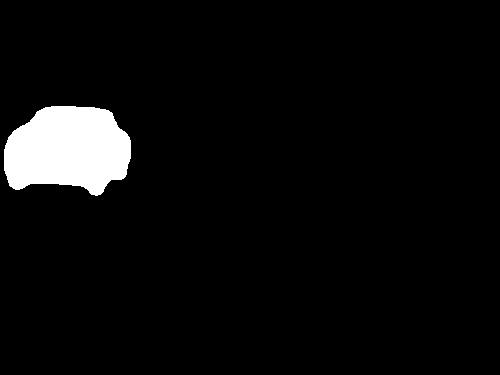

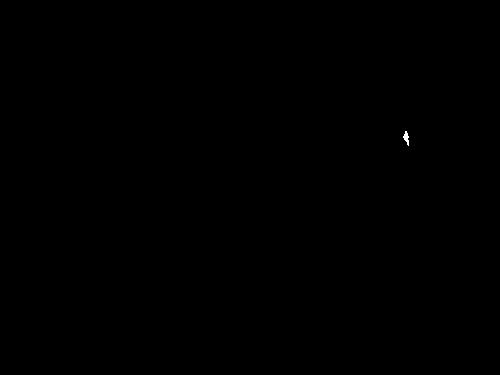

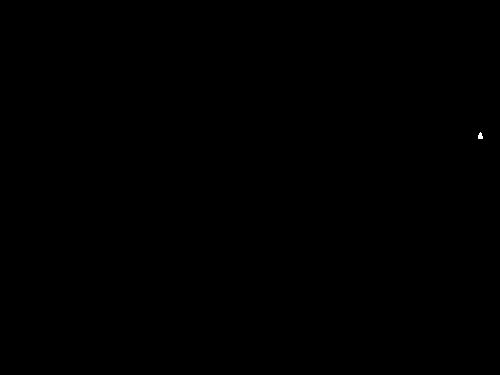

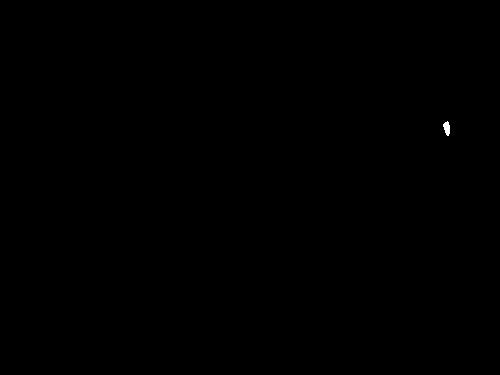

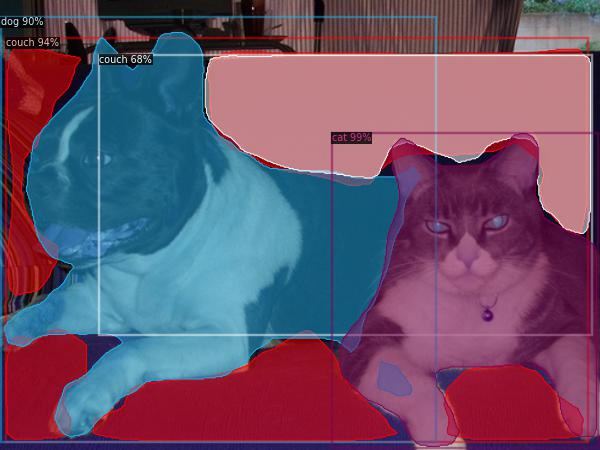

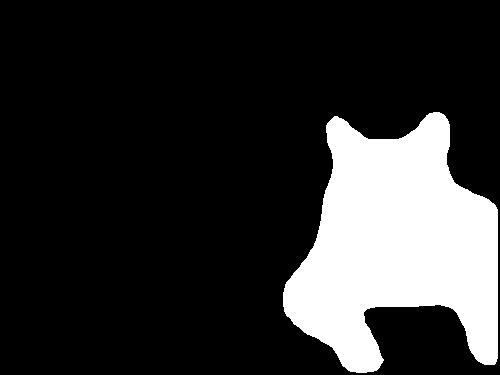

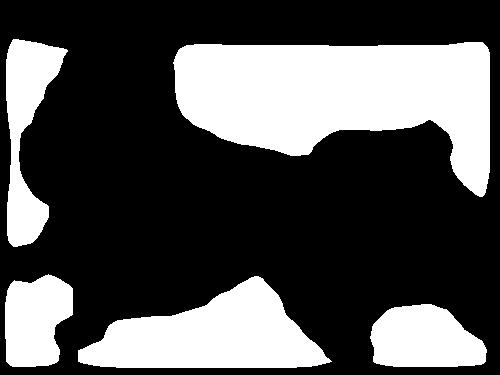

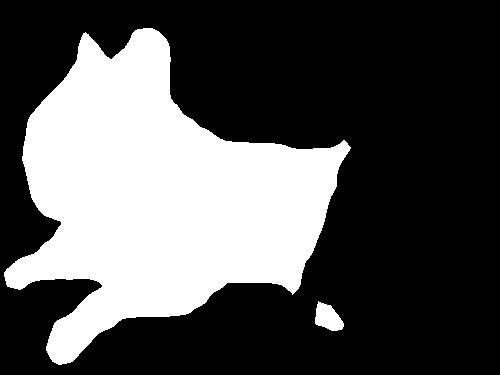

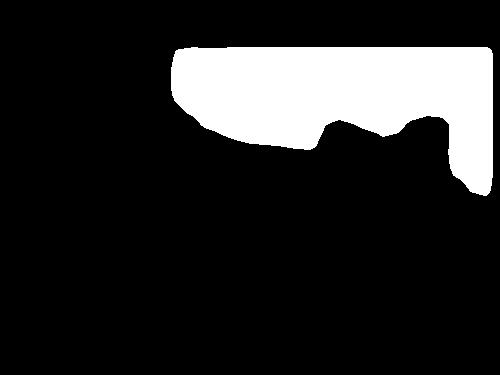

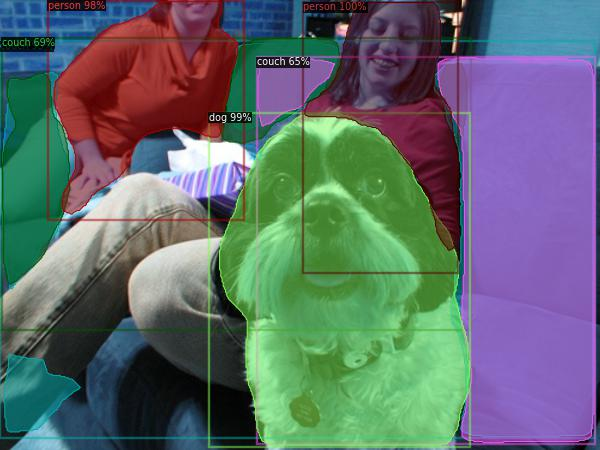

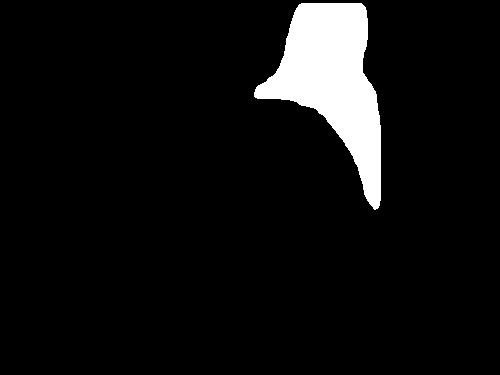

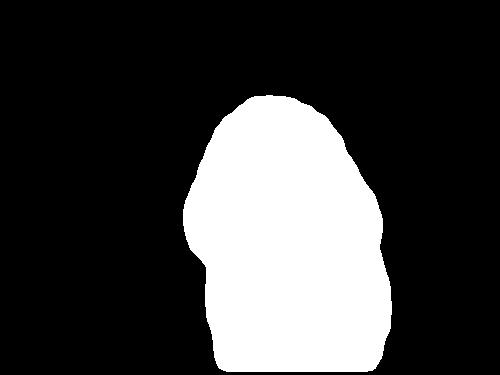

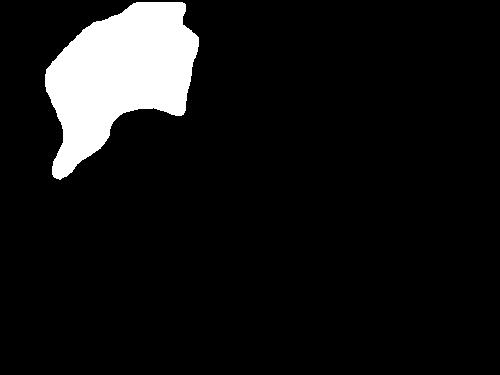

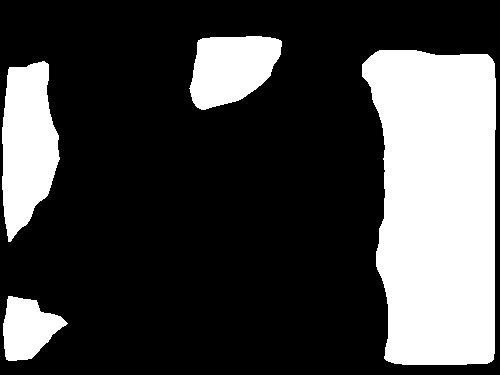

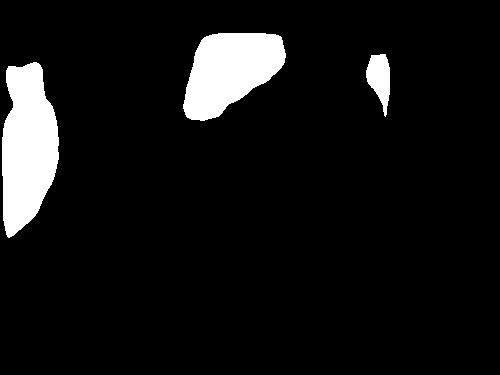

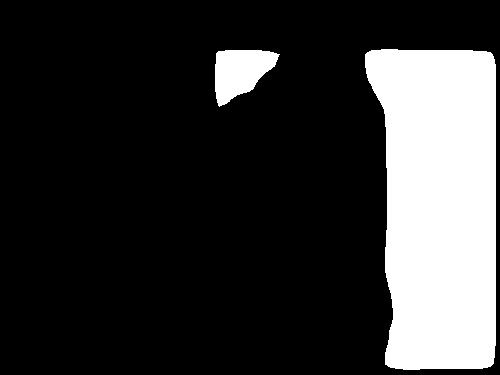

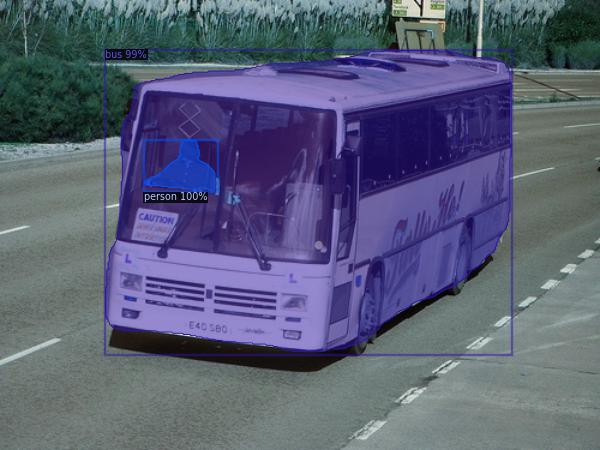

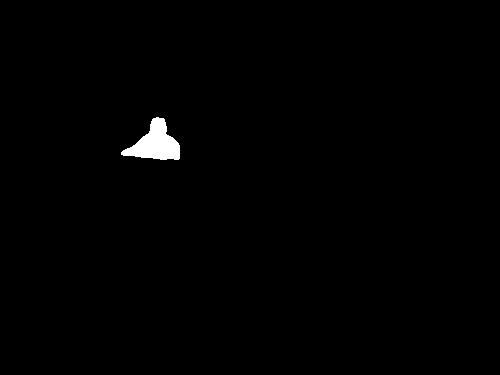

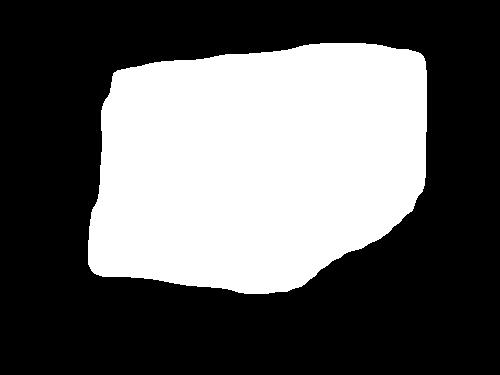

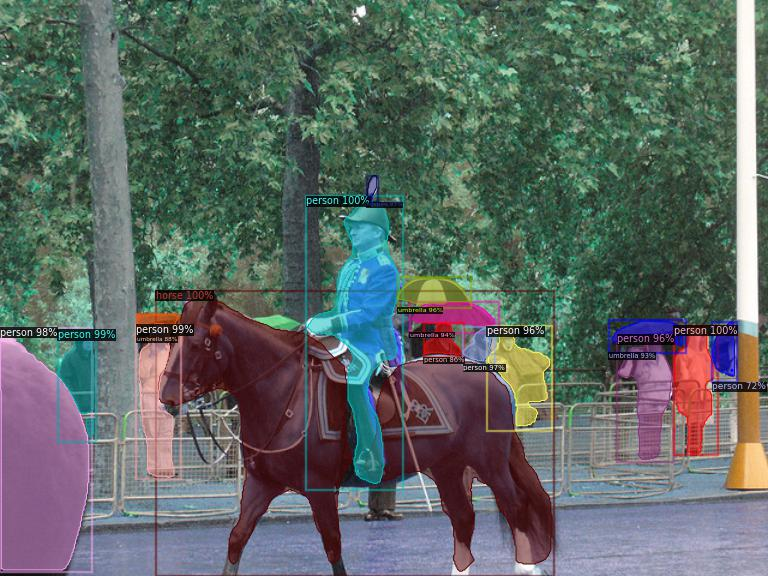

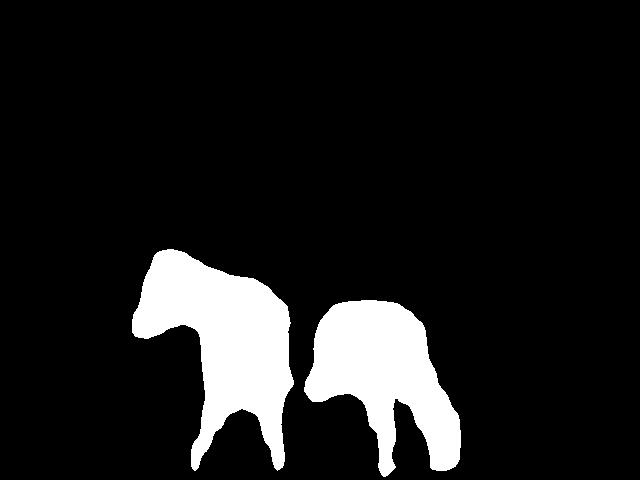

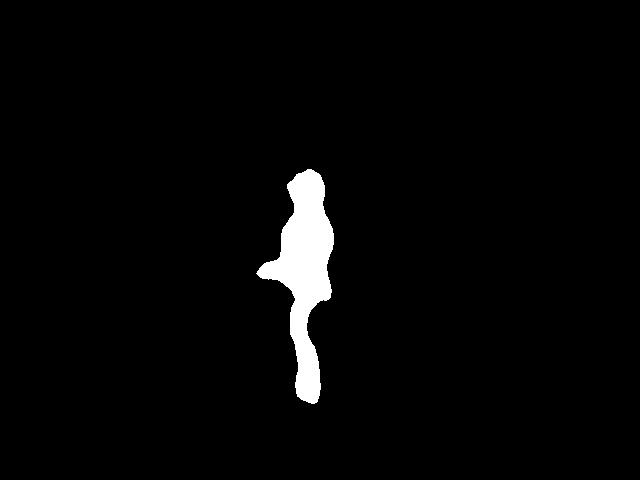

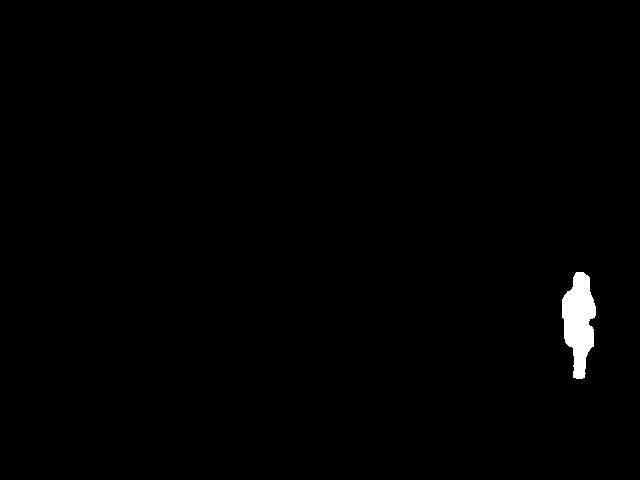

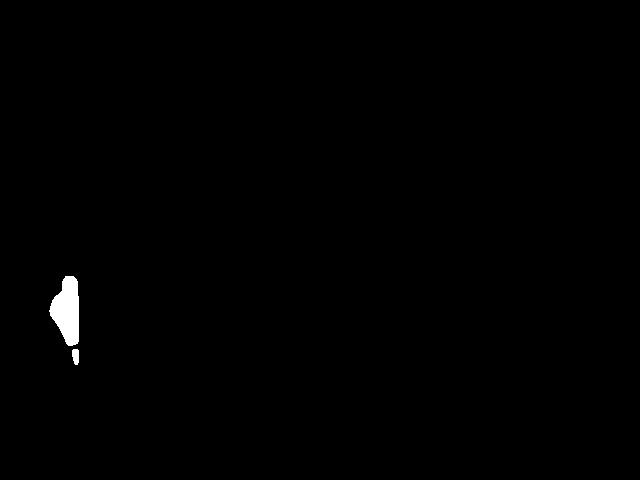

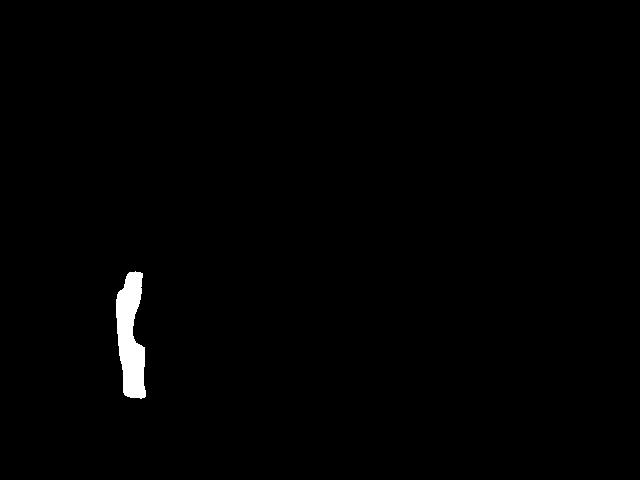

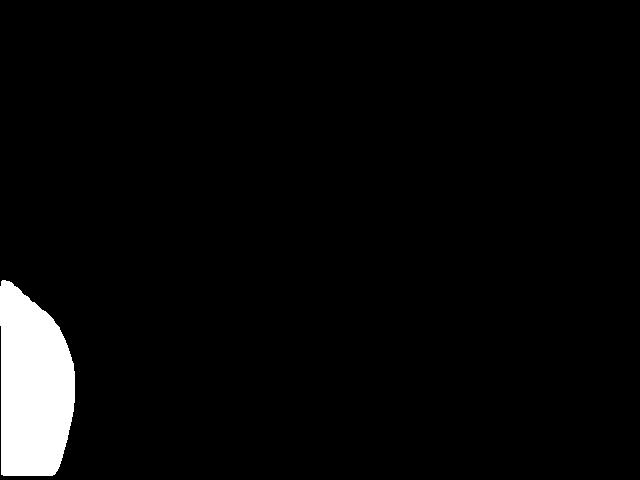

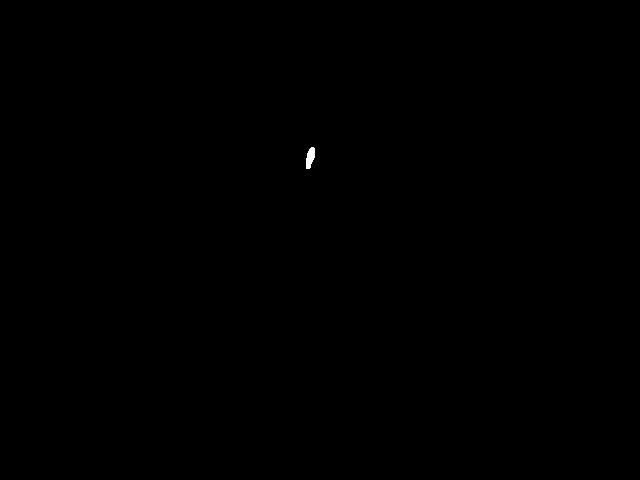

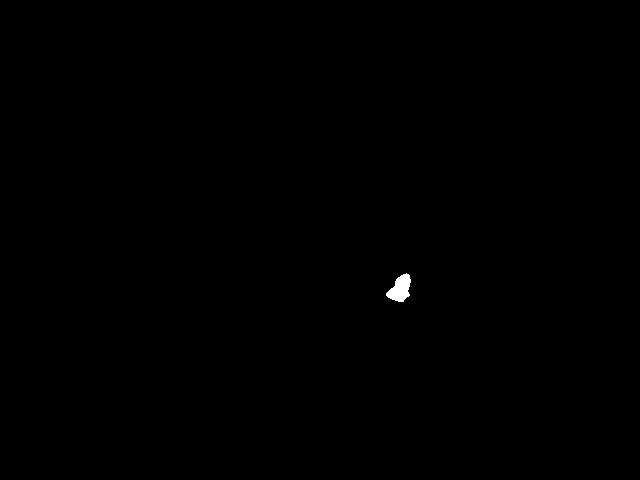

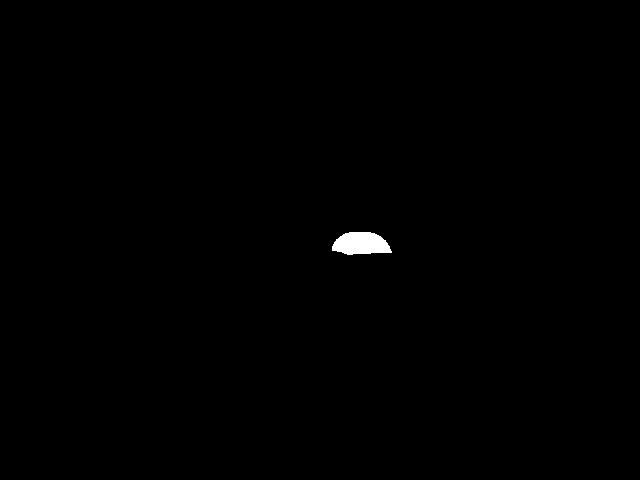

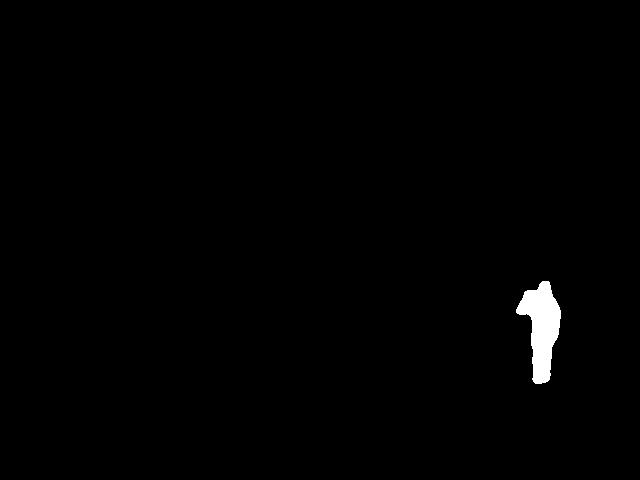

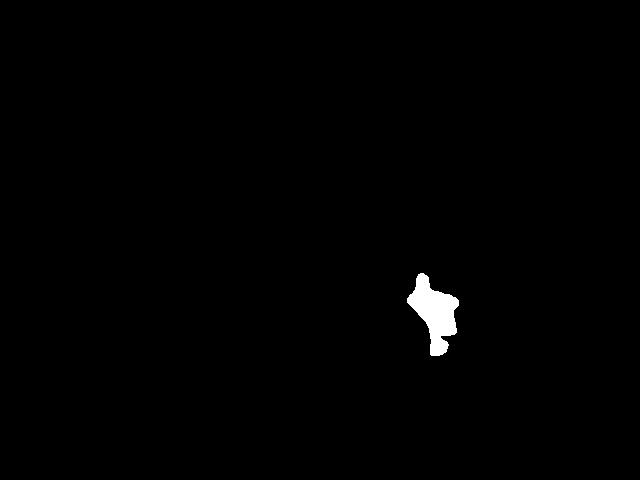

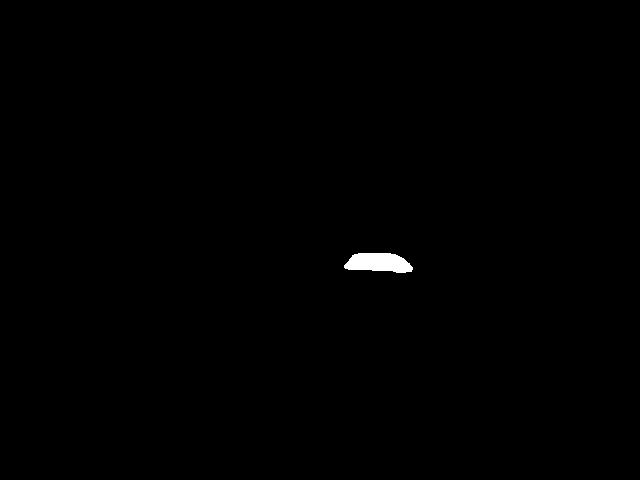

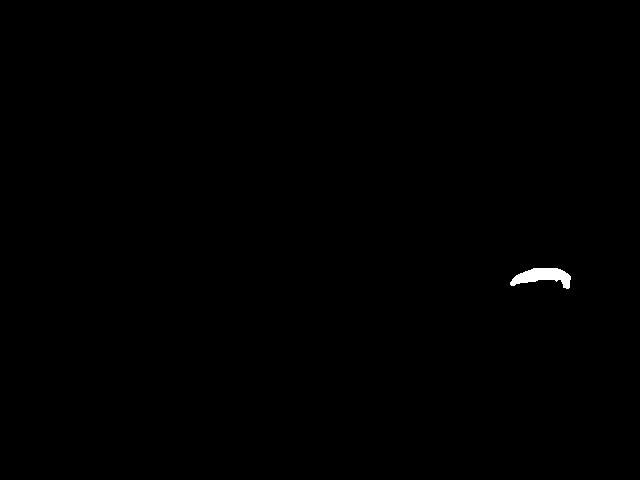

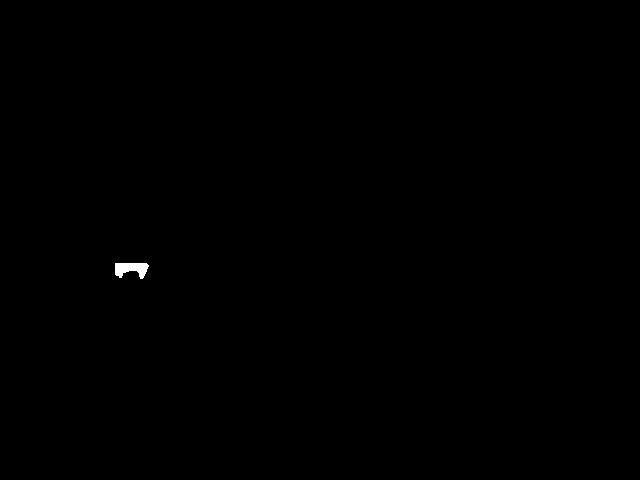

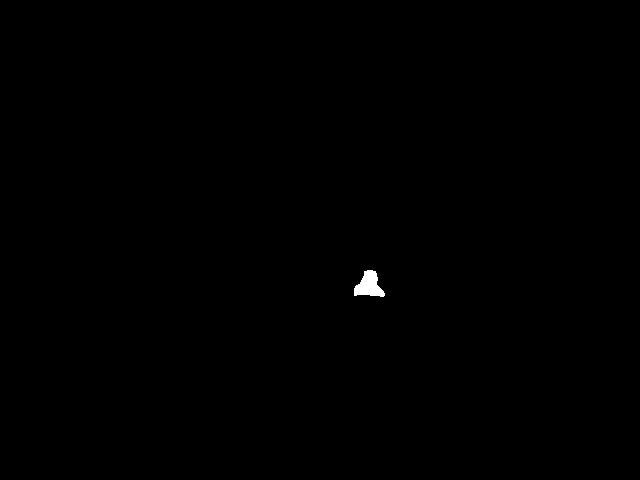

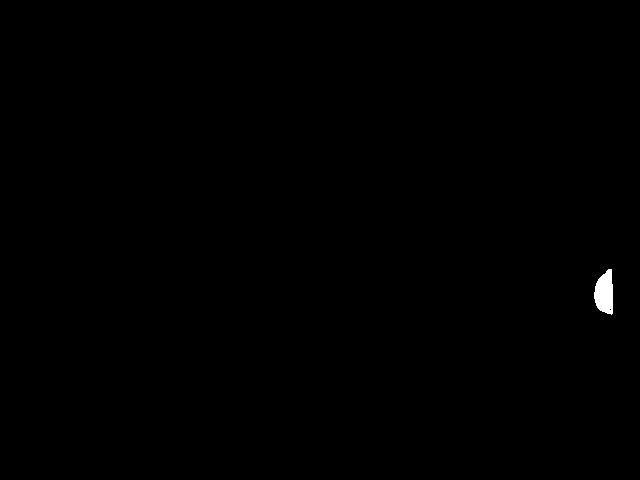

In [7]:
for img in ims[1:]:
    pred = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(pred["instances"].to("cpu"))
    final = np.full(img.shape, 255, dtype=np.uint8)[:,:,0]
    showarray(v.get_image()[:, :, ::-1])
    for mask in pred["instances"].get("pred_masks"):
        mask=mask.to("cpu")
        mask=mask.numpy()
        mask=mask.astype('uint8')
        # get first masked value (foreground)
        fg = cv2.bitwise_or(img, img, mask=mask)

        # get second masked value (background) mask must be inverted
        mask = cv2.bitwise_not(mask)
#         background = np.full(img.shape, 255, dtype=np.uint8)
#         bk = cv2.bitwise_or(background, background, mask=mask)

#         # combine foreground+background
#         final = cv2.bitwise_and(mask, final)
#         res = cv2.bitwise_or(im,im,mask = mask.astype('uint8'))
#         v = v.draw_binary_mask(mask)
        showarray(mask-255)
    
        